<a href="https://colab.research.google.com/github/cdiegor/Simulacao/blob/main/Seguros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Seguros — Simulação em SimPy

Este caderno implementa um sistema de seguros em **SimPy**:
- Chegadas de clientes com taxa \(\lambda\) (Poisson) e saídas com taxa \(\mu\) (vida ~ Exp(\(\mu\))).
- Incidentes por cliente com taxa \(\gamma\); custo do sinistro ~ Normal(\(x,d\)) **truncada em 0**.
- Cada cliente paga **prêmio periódico** de valor **c** a cada **\(\tau\)** unidades de tempo.
- Capital do segurador \(C(t)\) = prêmios acumulados − sinistros; opção de **parar na ruína**.


## Parâmetros
- `C0`: capital inicial
- `lam`, `mu`, `gamma`: taxas de chegada, saída e incidentes
- `premio_c`, `premio_tau`: prêmio periódico por cliente
- `sinistro_media`, `sinistro_sd`: parâmetros da Normal truncada
- `T_max`: horizonte de simulação; `parar_na_ruina`: interrompe em `C<0`


In [ ]:
!pip install simpy

In [ ]:
import numpy as np
import simpy
import math
import matplotlib.pyplot as plt

def make_rng(seed=None):
    return np.random.default_rng(seed)

def normal_trunc_zero(rng, mean, sd):
    z = rng.normal(mean, sd)
    return float(z) if z > 0 else 0.0


In [ ]:
class Cliente:
    """
    Cliente ativo: paga prêmio periódico e sofre incidentes até sair (Exp(mu)).
    """
    def __init__(self, env, sistema, id_cliente, rng, mu, gamma,
                 premio_c, premio_tau, sinistro_media, sinistro_sd):
        self.env = env; self.sistema = sistema; self.id = id_cliente; self.rng = rng
        self.mu = float(mu); self.gamma = float(gamma)
        self.premio_c = float(premio_c); self.premio_tau = float(premio_tau)
        self.sinistro_media = float(sinistro_media); self.sinistro_sd = float(sinistro_sd)
        self.ativo = True
        env.process(self._vida())
        env.process(self._premios())
        env.process(self._incidentes())

    def _vida(self):
        dur = self.rng.exponential(1.0 / self.mu)
        yield self.env.timeout(dur)
        self.ativo = False
        self.sistema.remover_cliente(self)

    def _premios(self):
        while self.ativo and self.sistema.vivo:
            yield self.env.timeout(self.premio_tau)
            if not (self.ativo and self.sistema.vivo): break
            self.sistema.registrar_premio(self.premio_c, origem=self.id)

    def _incidentes(self):
        while self.ativo and self.sistema.vivo:
            espera = self.rng.exponential(1.0 / self.gamma)
            yield self.env.timeout(espera)
            if not (self.ativo and self.sistema.vivo): break
            custo = normal_trunc_zero(self.rng, self.sinistro_media, self.sinistro_sd)
            self.sistema.registrar_sinistro(custo, origem=self.id)


In [ ]:
class SistemaSeguros:
    def __init__(self, C0, lam, mu, gamma, premio_c, premio_tau,
                 sinistro_media, sinistro_sd, T_max, seed=None, parar_na_ruina=True):
        self.rng = make_rng(seed); self.env = simpy.Environment()
        self.C = float(C0); self.lam = float(lam); self.mu = float(mu); self.gamma = float(gamma)
        self.premio_c = float(premio_c); self.premio_tau = float(premio_tau)
        self.sinistro_media = float(sinistro_media); self.sinistro_sd = float(sinistro_sd)
        self.T_max = float(T_max); self.parar_na_ruina = bool(parar_na_ruina)
        self.vivo = True; self.clientes = set(); self.prox_id = 0
        self.total_premios = 0.0; self.total_sinistros = 0.0; self.n_sinistros = 0
        self.chegadas = 0; self.saidas = 0
        self.hist_t = [0.0]; self.hist_C = [self.C]; self.hist_N = [0]
        self.env.process(self._chegadas())

    def _snap(self):
        self.hist_t.append(self.env.now); self.hist_C.append(self.C); self.hist_N.append(len(self.clientes))

    def registrar_premio(self, valor, origem=None):
        if not self.vivo: return
        self.C += valor; self.total_premios += valor; self._snap()

    def registrar_sinistro(self, custo, origem=None):
        if not self.vivo: return
        self.C -= custo; self.total_sinistros += custo; self.n_sinistros += 1; self._snap()
        if self.parar_na_ruina and self.C < 0: self.vivo = False

    def adicionar_cliente(self):
        c = Cliente(self.env, self, self.prox_id, self.rng, self.mu, self.gamma,
                    self.premio_c, self.premio_tau, self.sinistro_media, self.sinistro_sd)
        self.clientes.add(c); self.prox_id += 1

    def remover_cliente(self, c):
        self.clientes.discard(c); self.saidas += 1; self._snap()

    def _chegadas(self):
        while self.vivo:
            inter = self.rng.exponential(1.0 / self.lam)
            yield self.env.timeout(inter)
            if not self.vivo: break
            self.chegadas += 1; self.adicionar_cliente()

    def run(self):
        if self.parar_na_ruina:
            while self.vivo and self.env.now < self.T_max: self.env.step()
            t_final = self.env.now
        else:
            self.env.run(until=self.T_max); t_final = self.T_max
        if self.hist_t[-1] != t_final:
            self.hist_t.append(t_final); self.hist_C.append(self.C); self.hist_N.append(len(self.clientes))
        return self.resultados()

    def resultados(self):
        return {
            "arruinou": bool(self.C < 0), "t_final": float(self.hist_t[-1]), "C_final": float(self.C),
            "chegadas": int(self.chegadas), "saidas": int(self.saidas), "clientes_ativos": int(len(self.clientes)),
            "n_sinistros": int(self.n_sinistros), "total_premios": float(self.total_premios),
            "total_sinistros": float(self.total_sinistros),
            "traj_t": np.array(self.hist_t), "traj_C": np.array(self.hist_C), "traj_N": np.array(self.hist_N)
        }


In [ ]:
def simular_uma_replica(C0=1_000_000, lam=5.0, mu=0.2, gamma=0.05,
                        premio_c=100.0, premio_tau=1.0,
                        sinistro_media=500.0, sinistro_sd=200.0,
                        T_max=365.0, seed=None, parar_na_ruina=True):
    sis = SistemaSeguros(C0, lam, mu, gamma, premio_c, premio_tau,
                         sinistro_media, sinistro_sd, T_max,
                         seed=seed, parar_na_ruina=parar_na_ruina)
    return sis.run()


## Demonstração: uma trajetória


In [ ]:
params = dict(
    C0=2_000, lam=3.0, mu=0.2, gamma=0.1,
    premio_c=50.0, premio_tau=1.0,
    sinistro_media=500.0, sinistro_sd=200.0,
    T_max=365.0, seed=42, parar_na_ruina=True
)
res = simular_uma_replica(**params)
{k:v for k,v in res.items() if k not in ("traj_t","traj_C","traj_N")}


{'arruinou': True,
 't_final': 26.877129247664207,
 'C_final': -666.7579556652652,
 'chegadas': 84,
 'saidas': 72,
 'clientes_ativos': 12,
 'n_sinistros': 34,
 'total_premios': 15750.0,
 'total_sinistros': 18416.757955665267}

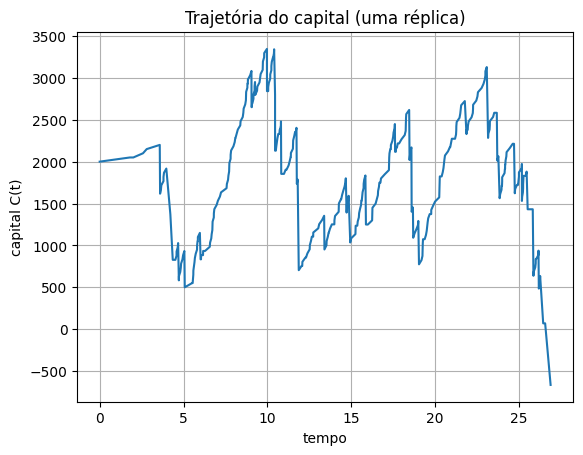

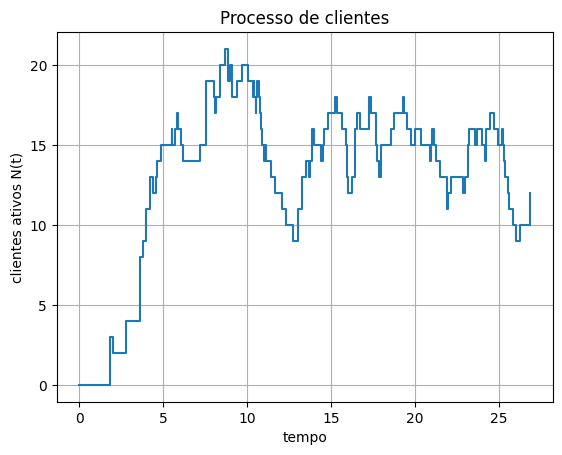

In [ ]:
plt.figure()
plt.plot(res["traj_t"], res["traj_C"])
plt.xlabel("tempo"); plt.ylabel("capital C(t)"); plt.title("Trajetória do capital (uma réplica)")
plt.grid(True); plt.show()

plt.figure()
plt.step(res["traj_t"], res["traj_N"], where='post')
plt.xlabel("tempo"); plt.ylabel("clientes ativos N(t)"); plt.title("Processo de clientes")
plt.grid(True); plt.show()


## Replicações: probabilidade de ruína e distribuição de C(T)


Prob. ruína ~ 0.0 ± 1.3859292911256333e-07
E[C(T)] ~ 3630742.0084358864 DP ~ 76416.53364198502


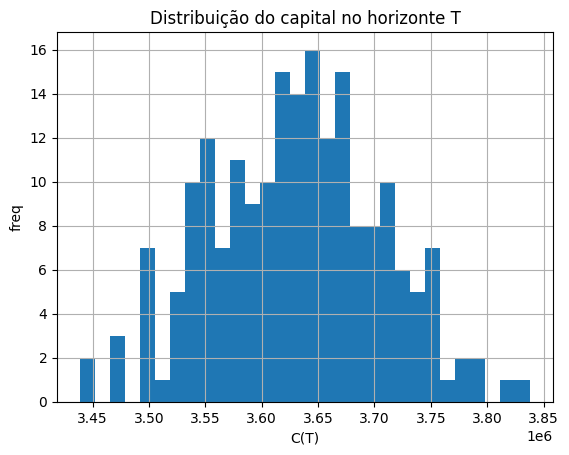

In [ ]:
def rodar_replicas(nrep=200, seed_base=1234, **kwargs):
    rng = make_rng(seed_base); resultados = []
    for r in range(nrep):
        seed = int(rng.integers(0, 2**63 - 1))
        resultados.append(simular_uma_replica(seed=seed, **kwargs))
    ruin = np.array([int(r["arruinou"]) for r in resultados])
    Cfinal = np.array([r["C_final"] for r in resultados])
    prob_ruina = ruin.mean()
    IC95 = 1.96 * math.sqrt(max(prob_ruina*(1-prob_ruina), 1e-12)/nrep)
    return {"prob_ruina": prob_ruina, "IC95_ruina": IC95,
            "E_Cfinal": Cfinal.mean(), "DP_Cfinal": Cfinal.std(ddof=1),
            "Cfinal": Cfinal, "resultados": resultados}

ag = rodar_replicas(
    nrep=200,
    C0=2_000_000, lam=3.0, mu=0.02, gamma=0.03,
    premio_c=50.0, premio_tau=1.0,
    sinistro_media=500.0, sinistro_sd=200.0,
    T_max=365.0, parar_na_ruina=True
)
print("Prob. ruína ~", ag["prob_ruina"], "±", ag["IC95_ruina"])
print("E[C(T)] ~", ag["E_Cfinal"], "DP ~", ag["DP_Cfinal"])

plt.figure()
plt.hist(ag["Cfinal"], bins=30)
plt.xlabel("C(T)"); plt.ylabel("freq"); plt.title("Distribuição do capital no horizonte T")
plt.grid(True); plt.show()


## Exercícios
1. **Severidade**: varie $(x,d)$ mantendo demais parâmetros; compare probabilidade de ruína e histograma de $C(T)$.
2. **Carga do sistema**: varie $(\lambda,\mu)$ para alterar $E[N]\approx \lambda/\mu$; discuta prêmios vs. sinistros.
3. **Prêmio na chegada**: adicione pagamento imediato na chegada e compare com o caso pós‑pago.
4. **Outra severidade**: troque Normal truncada por Lognormal/Pareto, mantendo $E[X]$ próximo; compare resultados.
5. **Tempo de ruína**: registre e estime quantis do tempo até ruína (quando ocorrer).
